# GMM

In [1]:
import numpy as np
from kmeans import KMeans

from data_loader import toy_dataset, load_digits
from utils import Figure
from matplotlib.patches import Ellipse

class GMM():
    '''
        Fits a Gausian Mixture model to the data.

        attrs:
            n_cluster : Number of mixtures (Int)
            e : error tolerance (Float) 
            max_iter : maximum number of updates (Int)
            init : initialization of means and variance
                Can be 'random' or 'kmeans' 
            means : means of Gaussian mixtures (n_cluster X D numpy array)
            variances : variance of Gaussian mixtures (n_cluster X D X D numpy array) 
            pi_k : mixture probabilities of different component ((n_cluster,) size numpy array)
    '''

    def __init__(self, n_cluster, init='k_means', max_iter=100, e=0.0001):
        self.n_cluster = n_cluster
        self.e = e
        self.max_iter = max_iter
        self.init = init
        self.means = None
        self.variances = None
        self.pi_k = None

    def fit(self, x):
        '''
            Fits a GMM to x.

            x: is a NXD size numpy array
            updates:
                self.means
                self.variances
                self.pi_k
        '''
        assert len(x.shape) == 2, 'x can only be 2 dimensional'

        np.random.seed(42)
        N, D = x.shape

        if (self.init == 'k_means'):
            # TODO
            # - comment/remove the exception
            # - initialize means using k-means clustering
            # - compute variance and pi_k (see P4.pdf)

            # DONOT MODIFY CODE ABOVE THIS LINE
            #raise Exception(
            #    'Implement initialization of variances, means, pi_k using k-means')
            
            kmean = KMeans(self.n_cluster, self.max_iter, self.e) # self.n_cluster self.max_iter 
            self.means, ymu, _ = kmean.fit(x) # self.means
            self.pi_k = np.array([np.sum(ymu == k) for k in range(self.n_cluster)]) / N #self.pi_k self.n_cluster
            
            # gamma_ik = {0, 1} at this initialize
            self.variances = np.zeros((self.n_cluster, D, D)) #self.variances self.n_cluster self.means
            for k in range(self.n_cluster):
                xt = x[ymu == k,:] - self.means[k,:] 
                self.variances[k, :, :] = np.dot(np.transpose(xt),xt) / np.sum(ymu==k) #self.variances 
            
            # DONOT MODIFY CODE BELOW THIS LINE

        elif (self.init == 'random'):
            # TODO
            # - comment/remove the exception
            # - initialize means randomly
            # - initialize variance to be identity and pi_k to be uniform

            # DONOT MODIFY CODE ABOVE THIS LINE
            #raise Exception(
            #    'Implement initialization of variances, means, pi_k randomly')
            
            self.means = np.random.rand(self.n_cluster, D) # self.means self.n_cluster
            self.pi_k = np.random.rand(self.n_cluster,) #self.pi_k self.n_cluster
            randvar = np.random.rand(self.n_cluster, D, D)
            self.variances = (randvar + np.transpose(randvar,(0,2,1))) / 2 #self.variances self.n_cluster
            
            
            # DONOT MODIFY CODE BELOW THIS LINE

        else:
            raise Exception('Invalid initialization provided')

        # TODO
        # - comment/remove the exception
        # - Use EM to learn the means, variances, and pi_k and assign them to self
        # - Update until convergence or until you have made self.max_iter updates.
        # - Return the number of E/M-Steps executed (Int) 
        # Hint: Try to separate E & M step for clarity
        # DONOT MODIFY CODE ABOVE THIS LINE
        #raise Exception('Implement fit function (filename: gmm.py)')
        
        #4
        l = self.compute_log_likelihood(x, self.means, self.variances, self.pi_k)
        gamma = np.zeros((N, self.n_cluster))
        
        
        def xnlike(pi, mea, var, x):
            gaus = self.Gaussian_pdf(mea, var).getLikelihood(x)
            return pi*gaus
        
        veclog = np.vectorize(xnlike)
           
        for itr in range(self.max_iter):
            print("Iteration,", itr)
            #print('variances', self.variances[0,:,:])
            #print('means', self.means[0,:] )
            # 6 E step
            
            #for k in range(self.n_cluster):
            #    gamma[:, k] = veclog(self.pi_k[k], self.means[k,:], self.variances[k,:], x)
            
            for n in range(N):
                sumnorm = .0
                normk = np.zeros(self.n_cluster)
                for k in range(self.n_cluster):
                    gaus = self.Gaussian_pdf(
                        self.means[k,:], self.variances[k,:]).getLikelihood(x[n,:])
                    #if gaus ==0:
                    #    print('gaus is 0 when n, k', n , k)
                    normk[k]= self.pi_k[k] * gaus
                    if np.isnan(normk[k]):
                        normk[k] =0                        
                    sumnorm += normk[k]

                #if n == (N-3):
                #    print('-2 ', normk, sumnorm)
                if sumnorm==0:
                    gamma[n, :] = 1/self.n_cluster
                else:
                    gamma[n, :] = normk / sumnorm
            
            print('min gamma', gamma[0])
            #print('gamma',gamma)
            #print('gamma -3 :', gamma[-3,:])
            #print(np.isnan(gamma[-3,0]))
            print('Estep')
            
            # 7 M step
            # eq.(5)
            Nk = np.sum(gamma, axis=0)
            #print('Nk',Nk)
            
            # eq.(6)
            means2 = np.zeros(self.means.shape)
            for k in range(self.n_cluster):
                means2[k, :] = np.sum(np.multiply(gamma[:, k].reshape(N,1), x), axis=0)/ Nk[k]
            
            print('means', means2[0,:])
            print('Eq6')
            # eq.(7)
            variances2 = np.zeros(self.variances.shape)
            for k in range(self.n_cluster):
                sumvark = np.zeros((D,D))
                for n in range(N):
                    xmu = x[n, :] - self.means[k, :]
                    sumvark += gamma[n, k]*(np.dot(np.transpose(xmu), xmu))
                variances2[k, :, :] = sumvark / Nk[k]
            print(variances2[0, :, :])
            
            print('Eq7')
            # eq.(8)
            self.pi_k = Nk / N
            self.means = means2
            self.variances = variances2
            print('variances', self.variances)
            print('Eq8')
            l1 = self.compute_log_likelihood(x, self.means, self.variances, self.pi_k)
            
            # stop condition
            if abs(l-l1) < self.e:
                break
            l = l1
            
        return itr
        
        # DONOT MODIFY CODE BELOW THIS LINE


    def sample(self, N):
        '''
        sample from the GMM model

        N is a positive integer
        return : NXD array of samples

        '''
        assert type(N) == int and N > 0, 'N should be a positive integer'
        np.random.seed(42)
        if (self.means is None):
            raise Exception('Train GMM before sampling')

        # TODO
        # - comment/remove the exception
        # - generate samples from the GMM
        # - return the samples

        # DONOT MODIFY CODE ABOVE THIS LINE
        #raise Exception('Implement sample function in gmm.py')
        samples = np.zeros((N, self.means.shape[1]))
        firstsa = np.random.choice(self.n_cluster, N, p=self.pi_k)
        print('means', self.means.shape)
        print('variance', self.variances.shape)
        print('firstsa ',firstsa[0])
        print('firstsa ', type(firstsa))
        for n in range(N):
            samples[n] = np.random.multivariate_normal(
                self.means[firstsa[n]], 
                self.variances[firstsa[n]])
        
        
        # DONOT MODIFY CODE BELOW THIS LINE
        return samples        

    def compute_log_likelihood(self, x, means=None, variances=None, pi_k=None):
        '''
            Return log-likelihood for the data

            x is a NXD matrix
            return : a float number which is the log-likelihood of data
        '''
        assert len(x.shape) == 2,  'x can only be 2 dimensional'
        if means is None:
            means = self.means
        if variances is None:
            variances = self.variances
        if pi_k is None:
            pi_k = self.pi_k    
        # TODO
        # - comment/remove the exception
        # - calculate log-likelihood using means, variances and pi_k attr in self
        # - return the log-likelihood (Float)
        # Note: you can call this function in fit function (if required)
        # DONOT MODIFY CODE ABOVE THIS LINE
        #raise Exception('Implement compute_log_likelihood function in gmm.py')
        N, D = x.shape
        K = self.pi_k.shape[0]
        log_likelihood = .0
        #for n in range(3):
        #for n in range(N):
        #    lnk = .0
        #    #print(lnk)
        #    for k in range(K):
        #        lnk += self.pi_k[k] * self.Gaussian_pdf(
        #           self.means[k,:], self.variances[k,:]).getLikelihood(x[n,:])
            #print(lnk)
        #    log_likelihood += np.log(lnk)
        log_likelihood = sum([np.log
                              (sum(
                                  [self.pi_k[k] * self.Gaussian_pdf(self.means[k,:], self.variances[k,:]).getLikelihood(x[n,:]) 
                                   for k in range(K)])) for n in range(N)])
        log_likelihood = log_likelihood.tolist()
        # DONOT MODIFY CODE BELOW THIS LINE
        return log_likelihood

    class Gaussian_pdf():
        def __init__(self,mean,variance):
            self.mean = mean
            self.variance = variance
            self.c = None
            self.inv = None
            '''
                Input: 
                    Means: A 1 X D numpy array of the Gaussian mean
                    Variance: A D X D numpy array of the Gaussian covariance matrix
                Output: 
                    None: 
            '''
            # TODO
            # - comment/remove the exception
            # - Set self.inv equal to the inverse the variance matrix (after ensuring it is full rank - see P4.pdf)
            # - Set self.c equal to ((2pi)^D) * det(variance) (after ensuring the variance matrix is full rank)
            # Note you can call this class in compute_log_likelihood and fit
            # DONOT MODIFY CODE ABOVE THIS LINE
            #raise Exception('Impliment Guassian_pdf __init__')
            D = self.variance.shape[1] # self.variance
            while np.linalg.matrix_rank(self.variance) != D: # self.variance
                #print('inverse')
                #print(self.variance)
                self.variance += 1e-3 * np.identity(D) # self.variance
            self.inv = np.linalg.inv(self.variance) # self.variance self.inv
            self.c = np.abs(((2*np.pi)**D) * np.linalg.det(self.variance)) # self.c self.variance            
            if self.c < 1e-100:
                self.c = 1e-100
            
            # DONOT MODIFY CODE BELOW THIS LINE

        def getLikelihood(self,x):
            '''
                Input: 
                    x: a 1 X D numpy array representing a sample
                Output: 
                    p: a numpy float, the likelihood sample x was generated by this Gaussian
                Hint: 
                    p = e^(-0.5(x-mean)*(inv(variance))*(x-mean)') / sqrt(c)
                    where ' is transpose and * is matrix multiplication
            '''
            #TODO
            # - Comment/remove the exception
            # - Calculate the likelihood of sample x generated by this Gaussian
            # Note: use the described implementation of a Gaussian to ensure compatibility with the solutions
            # DONOT MODIFY CODE ABOVE THIS LINE
            #raise Exception('Impliment Guassian_pdf getLikelihood')
            p = np.exp(-0.5 * np.dot(np.dot((x - self.mean), self.inv),
                                     np.transpose(x - self.mean))) / np.sqrt(self.c) # self.mean self.inv self.c
            if np.abs(p) < 1e-200:
                p = 1e-200
            elif np.isinf(p):
                p = np.exp(700)
            # DONOT MODIFY CODE BELOW THIS LINE
            return p

## test

In [18]:
def f_nk(n, k):
    return (n+2*np.exp(k))
nn = np.array([1,2,3,2,1])
kk = np.array([1, 5])
log_lnk = .0
for n in nn:
    lnk = .0
    for k in kk:
        lnk += f_nk(n,k)
    log_lnk += np.log(lnk)
print(log_lnk)

28.615624721270386


In [3]:
[k for k in range(5)]

[0, 1, 2, 3, 4]

In [4]:
sum([k for k in range(5)])

10

In [5]:
sum([np.log(sum([f_nk(n, k) for k in kk])) for n in nn])

28.615624721270386

In [6]:
a = sum([np.log(sum([f_nk(n, k) for k in kk])) for n in nn])
type(a)

numpy.float64

In [14]:
vfunc = np.vectorize(f_nk)
vfunc(nn,nn)

array([ 6.43656366, 16.7781122 , 43.17107385, 16.7781122 ,  6.43656366])

In [13]:
frofunc = np.frompyfunc(f_nk, 5,2)
frofunc(nn, kk)

ValueError: invalid number of arguments

In [5]:
np.array([0.000e+000, 2.902e-320, 0.000e+000, 0.000e+000])/2.902e-320

array([0., 1., 0., 0.])

In [6]:
bb = np.array([0.000e+000, 2.902e-320, 0.000e+000, 0.000e+000])


C:\Users\Takato\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


array([         -inf, -735.76178081,          -inf,          -inf])

In [18]:
1e-323

1e-323

In [19]:
1e-324

0.0

In [6]:
type(ll)

numpy.float64

In [10]:
type(ll.tolist())

float

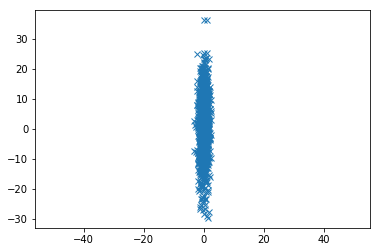

In [7]:
%matplotlib inline
mean = [0, 0]
cov = [[1, 0], [0, 100]] 

import matplotlib.pyplot as plt
x, y = np.random.multivariate_normal(mean, cov, 1000).T
plt.plot(x, y, 'x')
plt.axis('equal')
plt.show()

In [8]:
np.random.choice(5, 3, p=[0.1, 0, 0.3, 0.6, 0])

array([3, 2, 3], dtype=int64)

In [10]:
np.random.choice(4, 20)

array([0, 2, 3, 0, 1, 2, 0, 0, 3, 0, 3, 1, 3, 2, 0, 1, 3, 3, 3, 1])

In [13]:
np.random.multivariate_normal(mean, cov, 1).T

array([[0.83785379],
       [9.19560547]])

In [5]:
mean2 = [0.1, -0.1, 0]
cov2 = [[1.1, 0,0.1], [0, 100.6,0], [0, 0.6, 10]] 
np.random.multivariate_normal(mean2, cov2, 1)

C:\Users\Takato\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  This is separate from the ipykernel package so we can avoid doing imports until


array([[ 0.59145171, -6.14549855, -1.37112586]])

In [6]:
np.random.multivariate_normal(mean2, cov2)

C:\Users\Takato\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  """Entry point for launching an IPython kernel.


array([-0.01355634, -7.19886701,  2.24800598])

In [14]:
ccc=np.array(range(27)).reshape((3,3,3))

In [16]:
ccc[0]

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [ ]:
import numpy as np
from data_loader import toy_dataset, load_digits
from utils import Figure
from matplotlib.patches import Ellipse


def compute_elipse_params(variance):
    '''
        Compute elipse params for plotting from variance
    '''

    # http://www.cs.cornell.edu/cv/OtherPdf/Ellipse.pdf Slide 17
    # https://stackoverflow.com/a/41821484

    variance_inv = np.linalg.inv(variance)
    a = variance_inv[0, 0]
    c = variance_inv[1, 1]
    b = variance_inv[0, 1] + variance_inv[1, 0]

    M = (variance_inv + variance_inv.T) / 2
    eig, _ = np.linalg.eig(M)
    if (np.abs(eig[0] - a) < np.abs(eig[0] - c)):
        lambda1, lambda2 = eig
    else:
        lambda2, lambda1 = eig

    angle = np.arctan(b / (a - c)) / 2
    return np.sqrt(1 / lambda1), np.sqrt(1 / lambda2), angle


################################################################################
# GMM on 2D toy dataset
# The dataset is generated from N gaussian distributions equally spaced on N radius circle.
# Here, N=4
# You should be able to visualize the learnt gaussian distribution in plots folder
# Complete implementation of fit function for GMM class in gmm.py
################################################################################
x, y = toy_dataset(4, 100)
init = ['k_means', 'random']
'''
for i in init:
    n_cluster = 4
    gmm = GMM(n_cluster=n_cluster, max_iter=1000, init=i, e=1e-6)
    iterations = gmm.fit(x)
    ll = gmm.compute_log_likelihood(x)

    assert gmm.means.shape == (
        n_cluster, 2), 'means should be numpy array with {}X2 shape'.format(n_cluster)

    assert gmm.variances.shape == (
        n_cluster, 2, 2), 'variances should be numpy array with {}X2X2 shape'.format(n_cluster)

    assert gmm.pi_k.shape == (
        n_cluster,), 'pi_k should be numpy vector of size'.format(n_cluster)

    assert iterations > 0 and type(
        iterations) == int, 'Number of updates should be positive integer'

    assert type(ll) == float, 'log-likelihood should be float'

    print('GMM for toy dataset with {} init converged in {} iteration. Final log-likelihood of data: {}'.format(
        i, iterations, ll))

    np.savez('results/gmm_toy_{}.npz'.format(i), iterations=iterations,
             variances=gmm.variances, pi_k=gmm.pi_k, means=gmm.means, log_likelihood=ll, x=x, y=y)

    # plot
    fig = Figure()
    fig.ax.scatter(x[:, 0], x[:, 1], c=y)
    # fig.ax.scatter(gmm.means[:, 0], gmm.means[:, 1], c='red')
    for component in range(n_cluster):
        a, b, angle = compute_elipse_params(gmm.variances[component])
        e = Ellipse(xy=gmm.means[component], width=a * 5, height=b * 5,
                    angle=angle, alpha=gmm.pi_k[component])
        fig.ax.add_artist(e)
    fig.savefig('plots/gmm_toy_dataset_{}.png'.format(i))

'''
################################################################################
# GMM on digits dataset
# We fit a gaussian distribution on digits dataset and show generate samples from the distribution
# Complete implementation of sample function for GMM class in gmm.py
################################################################################

x_train, x_test, y_train, y_test = load_digits()

for i in init:
    n_cluster = 30
    gmm = GMM(n_cluster=n_cluster, max_iter=1000, init=i, e=1e-10)
    iterations = gmm.fit(x_train)
    ll = gmm.compute_log_likelihood(x_train)
    print('GMM for digits dataset with {} init converged in {} iterations. Final log-likelihood of data: {}'.format(i, iterations, ll))

    # plot cluster means
    means = gmm.means
    from matplotlib import pyplot as plt
    l = int(np.ceil(np.sqrt(n_cluster)))

    im = np.zeros((10 * l, 10 * l))
    for m in range(l):
        for n in range(l):
            if (m * l + n < n_cluster):
                im[10 * m:10 * m + 8, 10 * n:10 * n +
                    8] = means[m * l + n].reshape([8, 8])
    im = (im > 0) * im
    plt.imsave('plots/means_{}.png'.format(i), im, cmap='Greys')

    # plot samples
    N = 100
    l = int(np.ceil(np.sqrt(N)))
    samples = gmm.sample(N)

    assert samples.shape == (
        N, x_train.shape[1]), 'Samples should be numpy array with dimensions {}X{}'.format(N, x_train.shape[1])

    im = np.zeros((10 * l, 10 * l))
    for m in range(l):
        for n in range(l):
            if (m * l + n < N):
                im[10 * m: 10 * m + 8, 10 * n: 10 * n +
                    8] = samples[m * l + n].reshape([8, 8])
    im = (im > 0) * im
    plt.imsave('plots/samples_{}.png'.format(i), im, cmap='Greys')

    np.savez('results/gmm_digits_{}.npz'.format(i), iterations=np.array(
        [iterations]), variances=gmm.variances, pi_k=gmm.pi_k, means=gmm.means, samples=samples, log_likelihood=ll, x=x_test, y=y_test)


Iteration, 0
min gamma [4.15294554e-245 3.32235643e-245 4.98353465e-245 5.26039768e-245
 4.98353465e-245 4.98353465e-245 4.70667161e-245 6.64471286e-245
 5.39882920e-245 9.41334322e-245 1.59196246e-244 1.00000000e+000
 4.70667161e-245 4.01451402e-245 2.90706188e-245 1.93804125e-245
 5.81412376e-245 1.55510147e-236 8.02902804e-245 6.92157590e-245
 4.56824009e-245 7.19843894e-245 5.67569224e-245 3.46078795e-245
 1.62772316e-191 5.12196617e-245 6.45139463e-102 2.76863036e-245
 5.12196617e-245 1.49506039e-244]
Estep
means [0.00000000e+000 3.74921430e-230 1.40815348e-084 1.93750000e-001
 8.43750000e-001 2.16666667e-001 4.16666667e-003 3.90668607e-143
 2.77154668e-242 3.81366871e-229 2.50000000e-002 6.83333333e-001
 8.83333333e-001 1.91666667e-001 7.91666667e-002 3.75000000e-002
 2.54664865e-242 2.08333333e-003 3.66666667e-001 9.43750000e-001
 6.31250000e-001 3.62500000e-001 1.93750000e-001 3.33333333e-002
 6.59977419e-241 1.70833333e-001 8.62500000e-001 6.16666667e-001
 6.35416667e-001 5.31

Iteration, 2
min gamma [0.01921066 0.0180373  0.02780409 0.03264827 0.02260736 0.02186222
 0.02221751 0.0318049  0.04435025 0.0472424  0.11169958 0.01675842
 0.02073273 0.02309814 0.01856996 0.00866802 0.03335943 0.03750265
 0.05356523 0.0370133  0.0210607  0.03686195 0.03286184 0.01415291
 0.04043491 0.03282454 0.06154979 0.01800384 0.02762781 0.06586929]
Estep
means [0.00000000e+00 1.95341500e-02 3.26837416e-01 7.38817743e-01
 7.40627320e-01 3.63307350e-01 8.46789161e-02 8.30549369e-03
 3.71195249e-04 1.24628805e-01 6.42306978e-01 7.49211210e-01
 6.50287676e-01 5.17167780e-01 1.17483296e-01 7.37750557e-03
 2.31997030e-04 1.58871566e-01 6.07785820e-01 4.46223088e-01
 4.49703044e-01 4.95313660e-01 1.13724944e-01 3.20155902e-03
 9.27988122e-05 1.44858946e-01 5.57442465e-01 5.56236080e-01
 6.20545657e-01 4.72485152e-01 1.47410913e-01 1.39198218e-04
 0.00000000e+00 1.39151819e-01 4.71649963e-01 5.71315887e-01
 6.45230141e-01 5.38836303e-01 1.79380104e-01 0.00000000e+00
 6.95991091e-04 9.6

C:\Users\Takato\Anaconda3\lib\site-packages\ipykernel_launcher.py:135: RuntimeWarning: invalid value encountered in true_divide


min gamma [1.16456570e-37 1.13340474e-39 1.46647548e-42 7.35225006e-34
 1.46440356e-36 4.62495741e-39 5.79550647e-38 6.50590420e-38
 1.78762570e-39 4.79700250e-38 9.90413469e-39 4.65466988e-39
 8.06745304e-40 2.36717089e-38 2.78110554e-38 1.90353911e-34
 2.43408991e-96 1.98338673e-39 1.55019653e-37 8.15765072e-40
 9.61124327e-40 1.00000000e+00 5.30138657e-37 5.15574250e-38
 2.04351440e-40 1.39462653e-33 9.52550833e-38 4.45783773e-35
 1.30621063e-38 3.98390823e-47]
Estep
means [0.00000000e+000 4.47782490e-002 3.62886354e-001 5.58950709e-001
 7.39323908e-001 7.36080455e-001 2.80720975e-001 7.40618837e-003
 2.97055242e-018 1.79620383e-001 6.31964901e-001 8.18528618e-001
 5.98272950e-001 5.02711066e-001 2.57480060e-001 9.81469009e-004
 3.30112405e-014 2.04274888e-001 8.90049417e-001 3.78917931e-001
 3.36386836e-001 5.22163673e-001 1.69029608e-001 1.00345094e-003
 1.64615811e-014 8.09110479e-002 8.45354587e-001 8.33170930e-001
 4.43925654e-001 5.41907645e-001 9.71580733e-002 1.33005965e-015

C:\Users\Takato\Anaconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
C:\Users\Takato\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1794: RuntimeWarning: invalid value encountered in greater
  return count_nonzero(S > tol, axis=-1)


In [13]:
cc = np.array([1, 2, np.nan, 4])
for i in range(4):
    if np.isnan(cc[i]):
        print('Nan', i)

Nan 2


In [10]:
if np.max(np.isnan(cc)):
    print('Nan')

Nan


In [11]:
gg = np.random.rand(2, 3, 3)
ggn = np.array(range(18)).reshape((2,3,3))
print(ggn)
print(gg)
print('transe')
print(np.transpose(ggn,(0,2,1)))
print(np.transpose(gg,(0,2,1)))

[[[ 0  1  2]
  [ 3  4  5]
  [ 6  7  8]]

 [[ 9 10 11]
  [12 13 14]
  [15 16 17]]]
[[[0.47726202 0.75405397 0.26717342]
  [0.49590703 0.36502532 0.10166882]
  [0.90171461 0.7851453  0.51975875]]

 [[0.00338888 0.1457981  0.85378533]
  [0.95417619 0.4965308  0.01861974]
  [0.26099423 0.65128351 0.75485369]]]
transe
[[[ 0  3  6]
  [ 1  4  7]
  [ 2  5  8]]

 [[ 9 12 15]
  [10 13 16]
  [11 14 17]]]
[[[0.47726202 0.49590703 0.90171461]
  [0.75405397 0.36502532 0.7851453 ]
  [0.26717342 0.10166882 0.51975875]]

 [[0.00338888 0.95417619 0.26099423]
  [0.1457981  0.4965308  0.65128351]
  [0.85378533 0.01861974 0.75485369]]]


In [24]:
abc = np.array([np.nan , np.nan])

In [27]:
abc = np.ones(abc.shape).astype(float)  /2

In [28]:
abc

array([0.5, 0.5])

In [35]:
cc = np.exp(800)

In [37]:
np.isinf(cc)

True

In [38]:
np.exp(700)

1.0142320547350045e+304